## Importación de librerías

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import geopandas as gpd
from shapely.geometry import Point

In [85]:
# Configuración de estilo para las gráficas
sns.set(style="whitegrid")
# plt.rcParams['figure.figsize'] = (10, 6)

## Carga de los datos

In [66]:
# Cargar datos
ruta_datos_query = "./BioTIMEQuery_24_06_2021.csv"
samples = pd.read_csv(ruta_datos_query, dtype={'PLOT': str, 'GENUS': str, 'SPECIES': str, 'GENUS_SPECIES': str});
samples.head(5)

,Unnamed: 0,STUDY_ID,DAY,MONTH,YEAR,SAMPLE_DESC,PLOT,ID_SPECIES,LATITUDE,LONGITUDE,sum.allrawdata.ABUNDANCE,sum.allrawdata.BIOMASS,GENUS,SPECIES,GENUS_SPECIES
0,1,10,NaN,NaN,1984,47.400000_-95.120000_12_Control_0_Medium,12,22,47.4,-95.12,1.0,0.0,Acer,rubrum,Acer rubrum
1,2,10,NaN,NaN,1984,47.400000_-95.120000_12_Control_0_Medium,12,23,47.4,-95.12,3.0,0.0,Acer,saccharum,Acer saccharum
2,3,10,NaN,NaN,1984,47.400000_-95.120000_12_Control_0_Medium,12,24,47.4,-95.12,1.0,0.0,Acer,spicatum,Acer spicatum
3,4,10,NaN,NaN,1984,47.400000_-95.120000_12_Control_0_Medium,12,607,47.4,-95.12,12.0,0.0,Corylus,cornuta,Corylus cornuta
4,5,10,NaN,NaN,1984,47.400000_-95.120000_12_Control_0_Small,12,1911,47.4,-95.12,1.0,0.0,Populus,pinnata,Populus pinnata


In [67]:
ruta_Datos_md = "./BioTIMEMetadata_24_06_2021.csv"
studies = pd.read_csv(ruta_Datos_md, delimiter=',', encoding='ISO-8859-2', dtype={'REALM': str, 'CLIMATE': str, 'HABITAT': str, 'BIOME_MAP': str, 'DATA_SOURCE': str, 'DATE_STUDY_ADDED': str, 'ABUNDANCE_TYPE': str, 'BIOMASS_TYPE': str})
studies.head(5)

,STUDY_ID,REALM,CLIMATE,GENERAL_TREAT,TREATMENT,TREAT_COMMENTS,TREAT_DATE,HABITAT,PROTECTED_AREA,BIOME_MAP,...,WEB_LINK,DATA_SOURCE,METHODS,SUMMARY_METHODS,LINK_ID,COMMENTS,DATE_STUDY_ADDED,ABUNDANCE_TYPE,BIOMASS_TYPE,SAMPLE_DESC_NAME
0,10,Terrestrial,Temperate,NaN,NaN,NaN,NaN,Woodland,False,Temperate broadleaf and mixed forests,...,http://esapubs.org/archive/ecol/E082/011/defau...,Ecology,Itasca State Park. Minnesota. is a 13 000-ha f...,Plots,NaN,Dates added,Oct-12,Count,NaN,lat_long_treefallid_controlvs.treatment_basevs...
1,18,Terrestrial,Temperate,NaN,NaN,NaN,NaN,Sagebrush steppe,False,Deserts and xeric shrublands,...,http://esapubs.org/archive/ecol/E091/243/defau...,Ecology,Site descriptionThe U.S. Sheep Experiment Stat...,Plots,NaN,Dates added Years (1923. 1926. 1927. 1929) del...,Oct-12,Count,NaN,lat_long_quadrat_year
2,33,Marine,Temperate,NaN,NaN,NaN,NaN,Seaweed beds,False,Temperate shelf and seas ecoregions,...,http://plankt.oxfordjournals.org/content/32/5.toc,Oxford Journals,Sampling and enumeration of phytoplanktonWeekl...,Stations,NaN,Inaccurate decimal latitude/longitude conversi...,Oct-12,Count,NaN,lat_long_location_method_date
3,39,Terrestrial,Temperate,NaN,NaN,NaN,NaN,Deciduous forest,False,Temperate broadleaf and mixed forests,...,http://www.esajournals.org/toc/emon/56/3,Ecology,This study was conducted in the Hubbard Brook ...,Plots,NaN,Removed records prior to 1986 as per provider ...,Oct-12,Density,NaN,lat_long_timeTransect_year
4,41,Terrestrial,Temperate,NaN,NaN,NaN,NaN,Woodland,False,Temperate broadleaf and mixed forests,...,http://www.esajournals.org/toc/ecol/41/4,Ecology,Time and space and the variation of species - ...,Counts,NaN,Dates added,Oct-12,Count,NaN,lat_long_census_year


A continuación nos damos una breve idea de los datos faltantes para realizar la posterior preparación de los mismos:

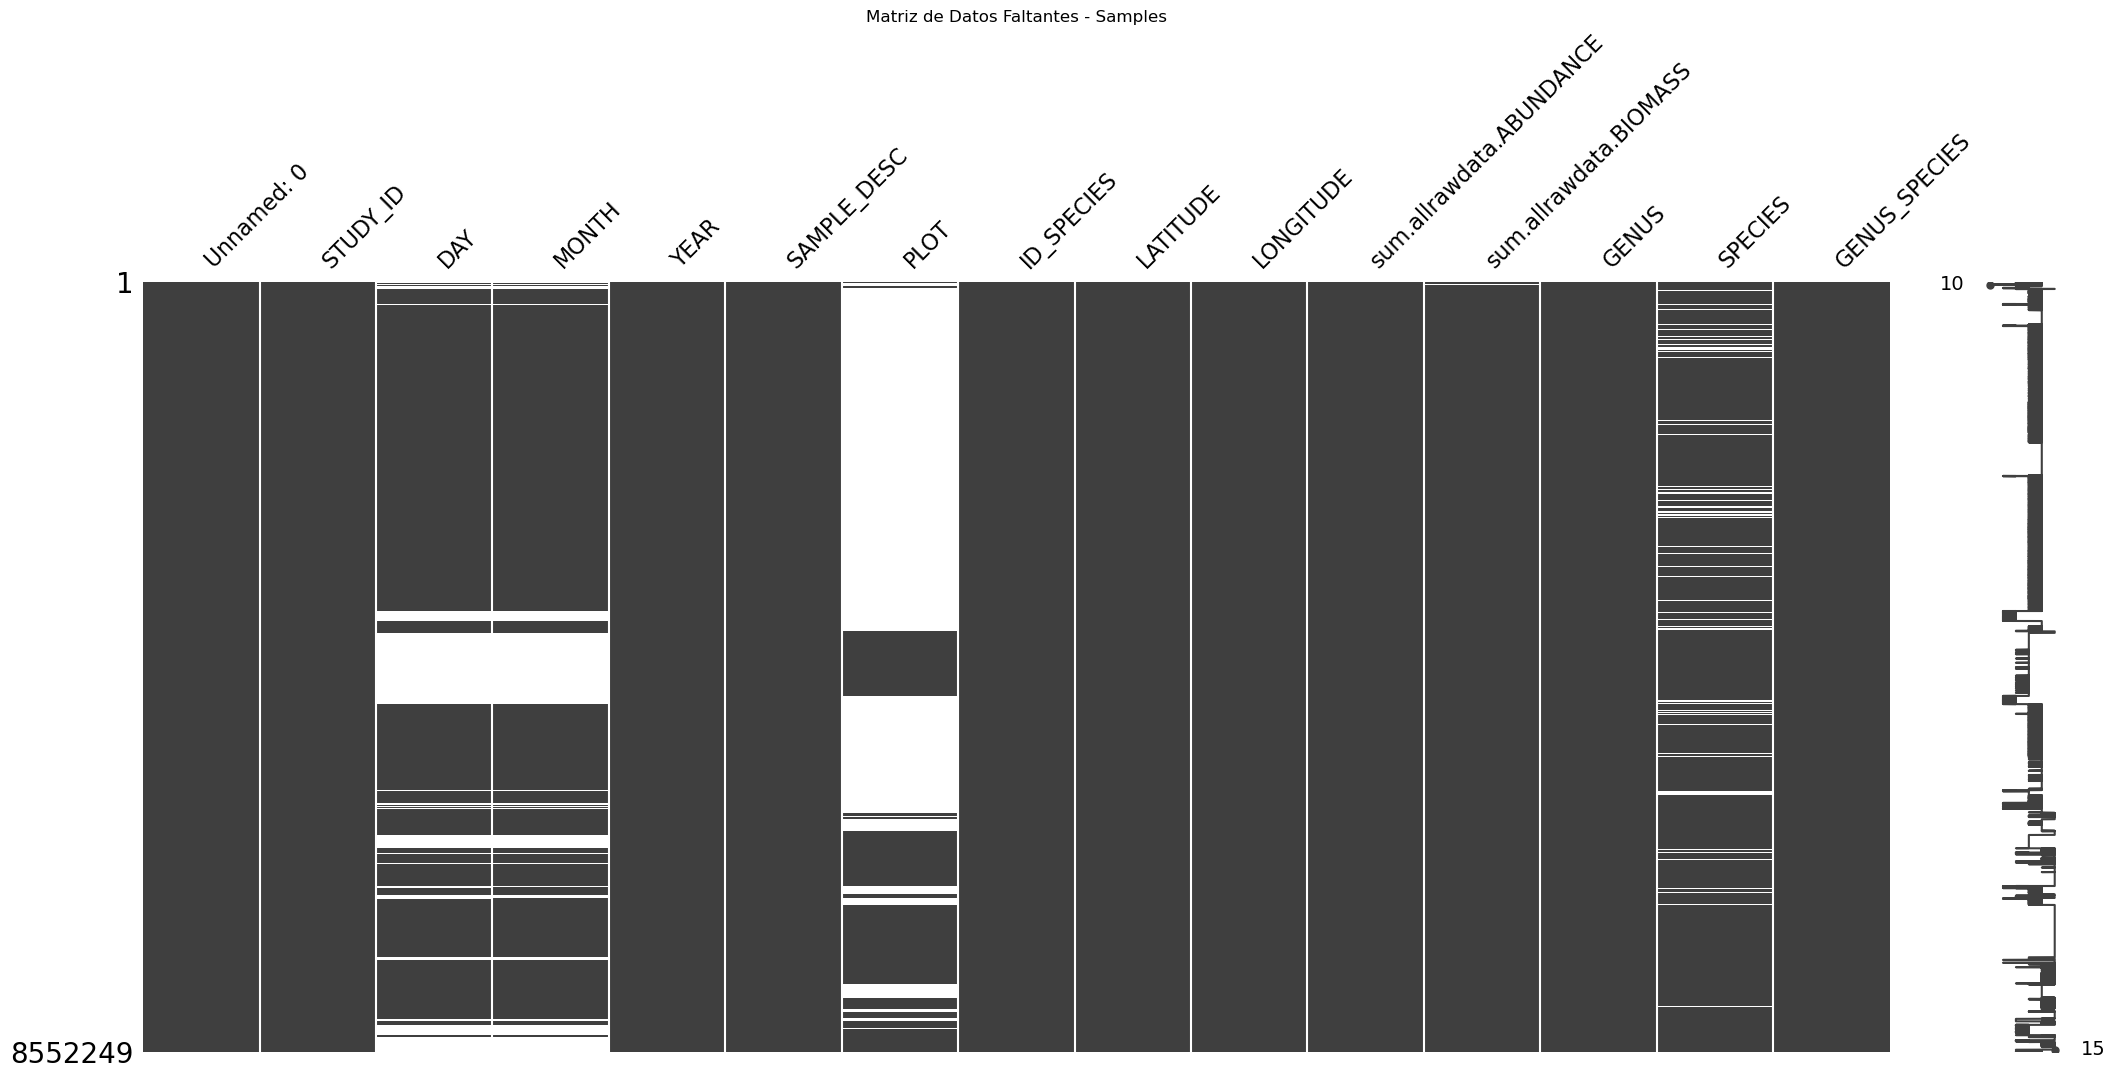

In [68]:
msno.matrix(samples)
plt.title("Matriz de Datos Faltantes - Samples")
plt.show()  

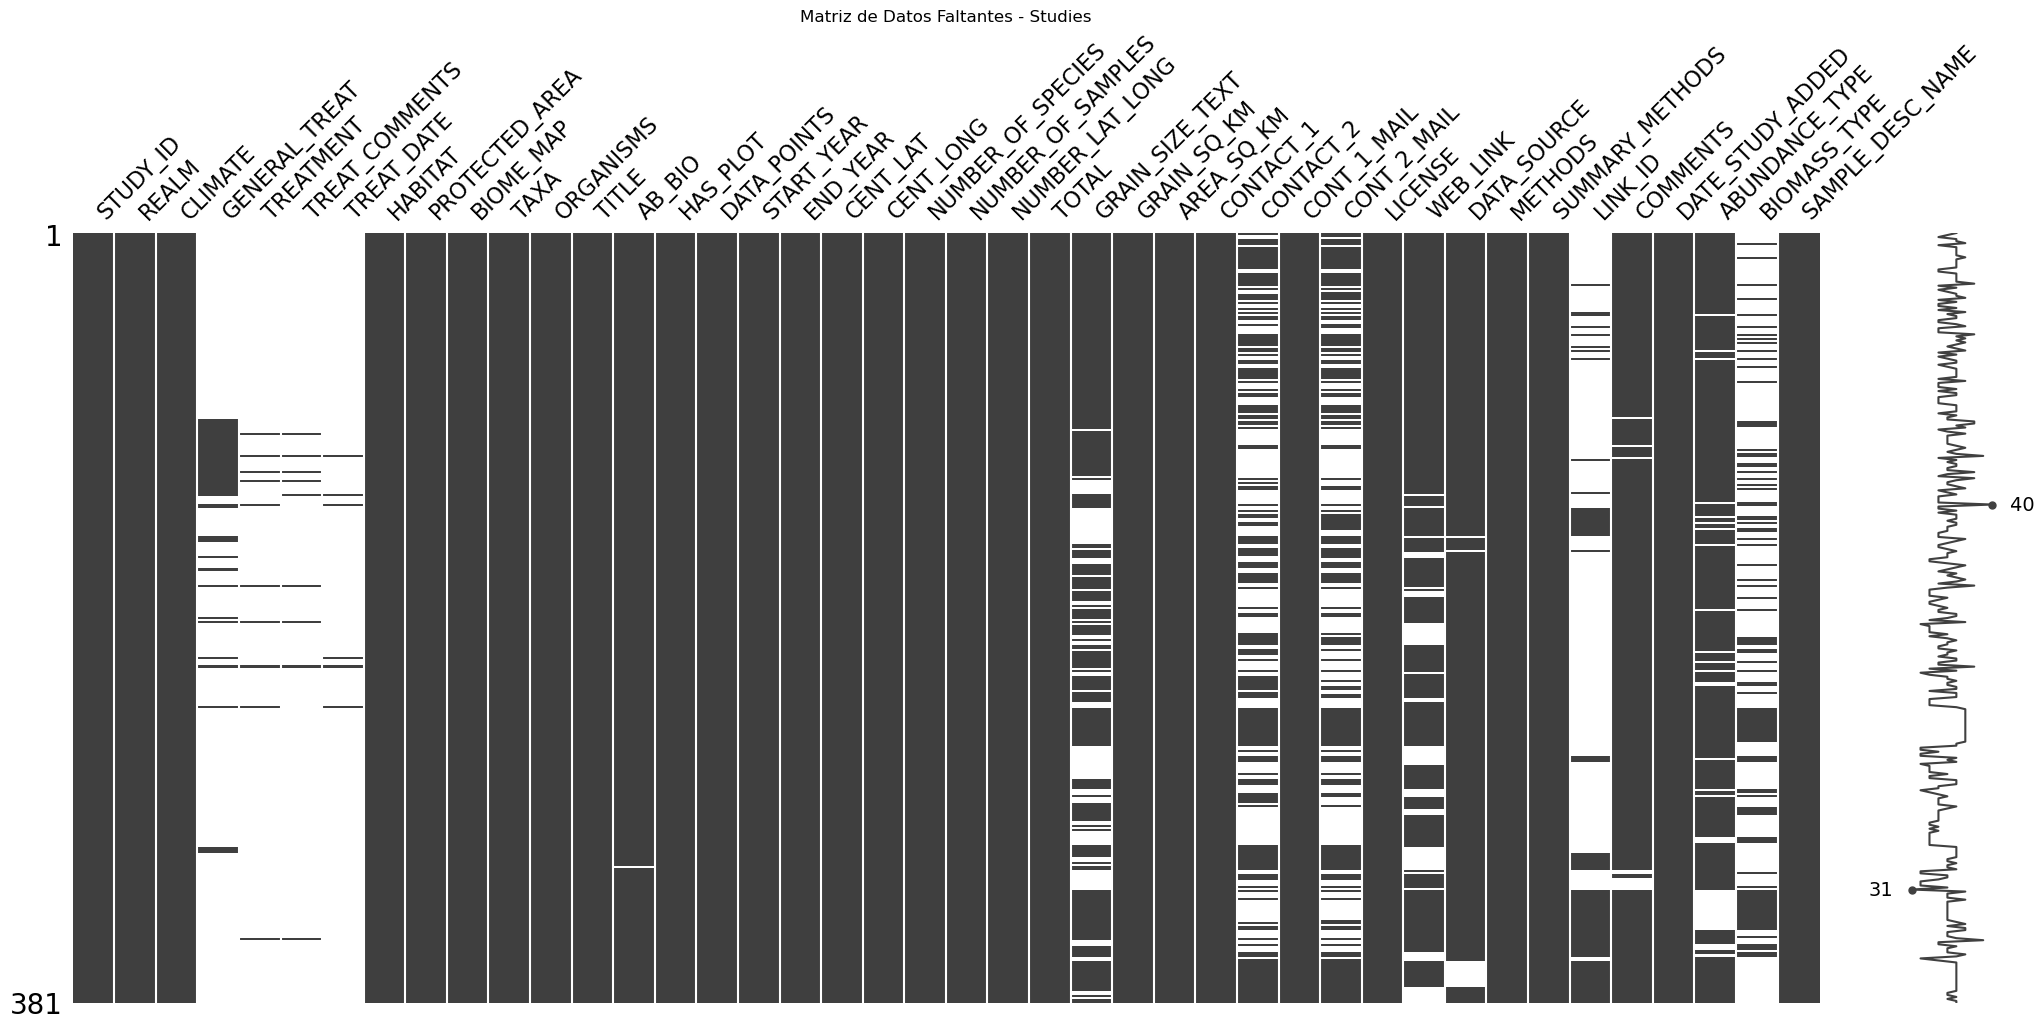

In [58]:
msno.matrix(studies)
plt.title("Matriz de Datos Faltantes - Studies")
plt.show()

## Preparación de los datos

Veamos primero que para el dataframe "BioTIMEQuery" tenemos datos que no nos sirven para analizar:

- Day y Month: Ya que lo que nos va a interesar es revisar el cambio en los años, ya que el cambio entre días o meses es casi inperceptible.
- SAMPLE_DESC: Es una descripción de la muestra tomada, lo que, para análisis, no nos sirve.
- Plot: Es una string que nos dice si el estudio original contiene gráficos, lo cual para este análisis no nos sirve, salvo para contrastar gráficos.
- sum.allrawdata.BIOMASS: Este atributo nos dice la biomasa total observada en la muestra, sin embargo, esta es 0 para cada registro. Por tanto, no podemos obtener información relevante de esta.

In [69]:
# Eliminar columnas innecesarias en studies (BioTIMEMetadata)
columns_to_drop_studies = ["GENERAL_TREAT", "TREATMENT", "TREAT_COMMENTS", "TREAT_DATE", 
                           "GRAIN_SIZE_TEXT", "CONTACT_1", "CONTACT_2", "CONT_1_MAIL", "CONT_2_MAIL", 
                           "LICENSE", "WEB_LINK", "DATA_SOURCE", "METHODS", "SUMMARY_METHODS", 
                           "LINK_ID", "COMMENTS", "ABUNDANCE_TYPE", "BIOMASS_TYPE", "SAMPLE_DESC_NAME",
                           "NUMBER_LAT_LONG", "TITLE"]
studies = studies.drop(columns=columns_to_drop_studies, errors='ignore')

In [70]:
# Eliminar columnas innecesarias en samples (BioTIMEQuery)
columns_to_drop_samples = ["DAY", "MONTH", "SAMPLE_DESC", "PLOT", "SPECIES", "Unnamed: 0"]
samples = samples.drop(columns=columns_to_drop_samples, errors='ignore')

A continuación realizamos una limpieza de los datos utilizando el método del rango intercuartílico (IQR) para detectar y eliminar outliers, adicionalmente eliminamos algunas columnas que no son relevantes para nuestro análisis.

In [71]:
# Función para eliminar outliers usando el rango intercuartílico (IQR)
def remove_outliers(df, columns):
    for col in columns:
        if df[col].dtype in ['float64', 'int64']:  # Solo aplicar a columnas numéricas
            
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

In [72]:
# Seleccionar columnas numéricas en cada dataset
# numeric_cols_samples = samples.select_dtypes(include=['float64', 'int64']).columns
# numeric_cols_studies = studies.select_dtypes(include=['float64', 'int64']).columns
numeric_cols_samples = ['sum.allrawdata.ABUNDANCE', 'sum.allrawdata.BIOMASS']
numeric_cols_studies = []

# Filtrar outliers en ambos datasets
samples_cleaned = remove_outliers(samples, numeric_cols_samples)
studies_cleaned = remove_outliers(studies, numeric_cols_studies)

In [95]:
# Mostrar la cantidad de filas antes y después del filtrado
print(f"Filas en 'samples' antes del filtrado: {len(samples)}, después: {len(samples_cleaned)}")
print(f"Filas en 'studies' antes del filtrado: {len(studies)}, después: {len(studies_cleaned)}")

Filas en 'samples' antes del filtrado: 8552249, después: 5688743
Filas en 'studies' antes del filtrado: 381, después: 381


## Análisis exploratorio de los datos

### Dataframe Samples

Dimensiones y muestra de datos:

In [96]:
print("Dimensiones de samples:", samples_cleaned.shape)

Dimensiones de samples: (5688743, 9)


In [97]:
samples_cleaned.head(5)

,STUDY_ID,YEAR,ID_SPECIES,LATITUDE,LONGITUDE,sum.allrawdata.ABUNDANCE,sum.allrawdata.BIOMASS,GENUS,GENUS_SPECIES
0,10,1984,22,47.4,-95.12,1.0,0.0,Acer,Acer rubrum
1,10,1984,23,47.4,-95.12,3.0,0.0,Acer,Acer saccharum
2,10,1984,24,47.4,-95.12,1.0,0.0,Acer,Acer spicatum
3,10,1984,607,47.4,-95.12,12.0,0.0,Corylus,Corylus cornuta
4,10,1984,1911,47.4,-95.12,1.0,0.0,Populus,Populus pinnata


Información general:

In [98]:
print(samples_cleaned.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
Index: 5688743 entries, 0 to 8526066
Data columns (total 9 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   STUDY_ID                  int64  
 1   YEAR                      int64  
 2   ID_SPECIES                int64  
 3   LATITUDE                  float64
 4   LONGITUDE                 float64
 5   sum.allrawdata.ABUNDANCE  float64
 6   sum.allrawdata.BIOMASS    float64
 7   GENUS                     object 
 8   GENUS_SPECIES             object 
dtypes: float64(4), int64(3), object(2)
memory usage: 434.0+ MB
None 



Estadísticos descriptivos:

In [99]:
print(samples_cleaned.describe(), "\n")

           STUDY_ID          YEAR    ID_SPECIES      LATITUDE     LONGITUDE  \
count  5.688743e+06  5.688743e+06  5.688743e+06  5.688743e+06  5.688743e+06   
mean   2.159586e+02  1.993370e+03  1.647243e+04  3.097264e+01 -3.687220e+01   
std    1.028462e+02  1.510873e+01  1.500457e+04  2.824556e+01  8.664221e+01   
min    1.000000e+01  1.874000e+03  1.000000e+00 -8.898167e+01 -1.800000e+02   
25%    1.290000e+02  1.986000e+03  4.598000e+03  2.851000e+01 -9.647200e+01   
50%    1.950000e+02  1.996000e+03  8.740000e+03  3.916470e+01 -7.064000e+01   
75%    2.540000e+02  2.003000e+03  2.663200e+04  4.674256e+01 -2.001360e+00   
max    5.160000e+02  2.016000e+03  5.205700e+04  8.970000e+01  1.800000e+02   

       sum.allrawdata.ABUNDANCE  sum.allrawdata.BIOMASS  
count              5.688743e+06            5.688743e+06  
mean               2.453589e+00            7.096013e-02  
std                2.720647e+00            2.048569e-01  
min                0.000000e+00            0.000000e+00 

Conteo de valores faltantes:

In [100]:
# Conteo de valores faltantes por columna
print("Valores faltantes en samples:")
print(samples_cleaned.isnull().sum(), "\n")

Valores faltantes en samples:
STUDY_ID                    0
YEAR                        0
ID_SPECIES                  0
LATITUDE                    0
LONGITUDE                   0
sum.allrawdata.ABUNDANCE    0
sum.allrawdata.BIOMASS      0
GENUS                       0
GENUS_SPECIES               0
dtype: int64 



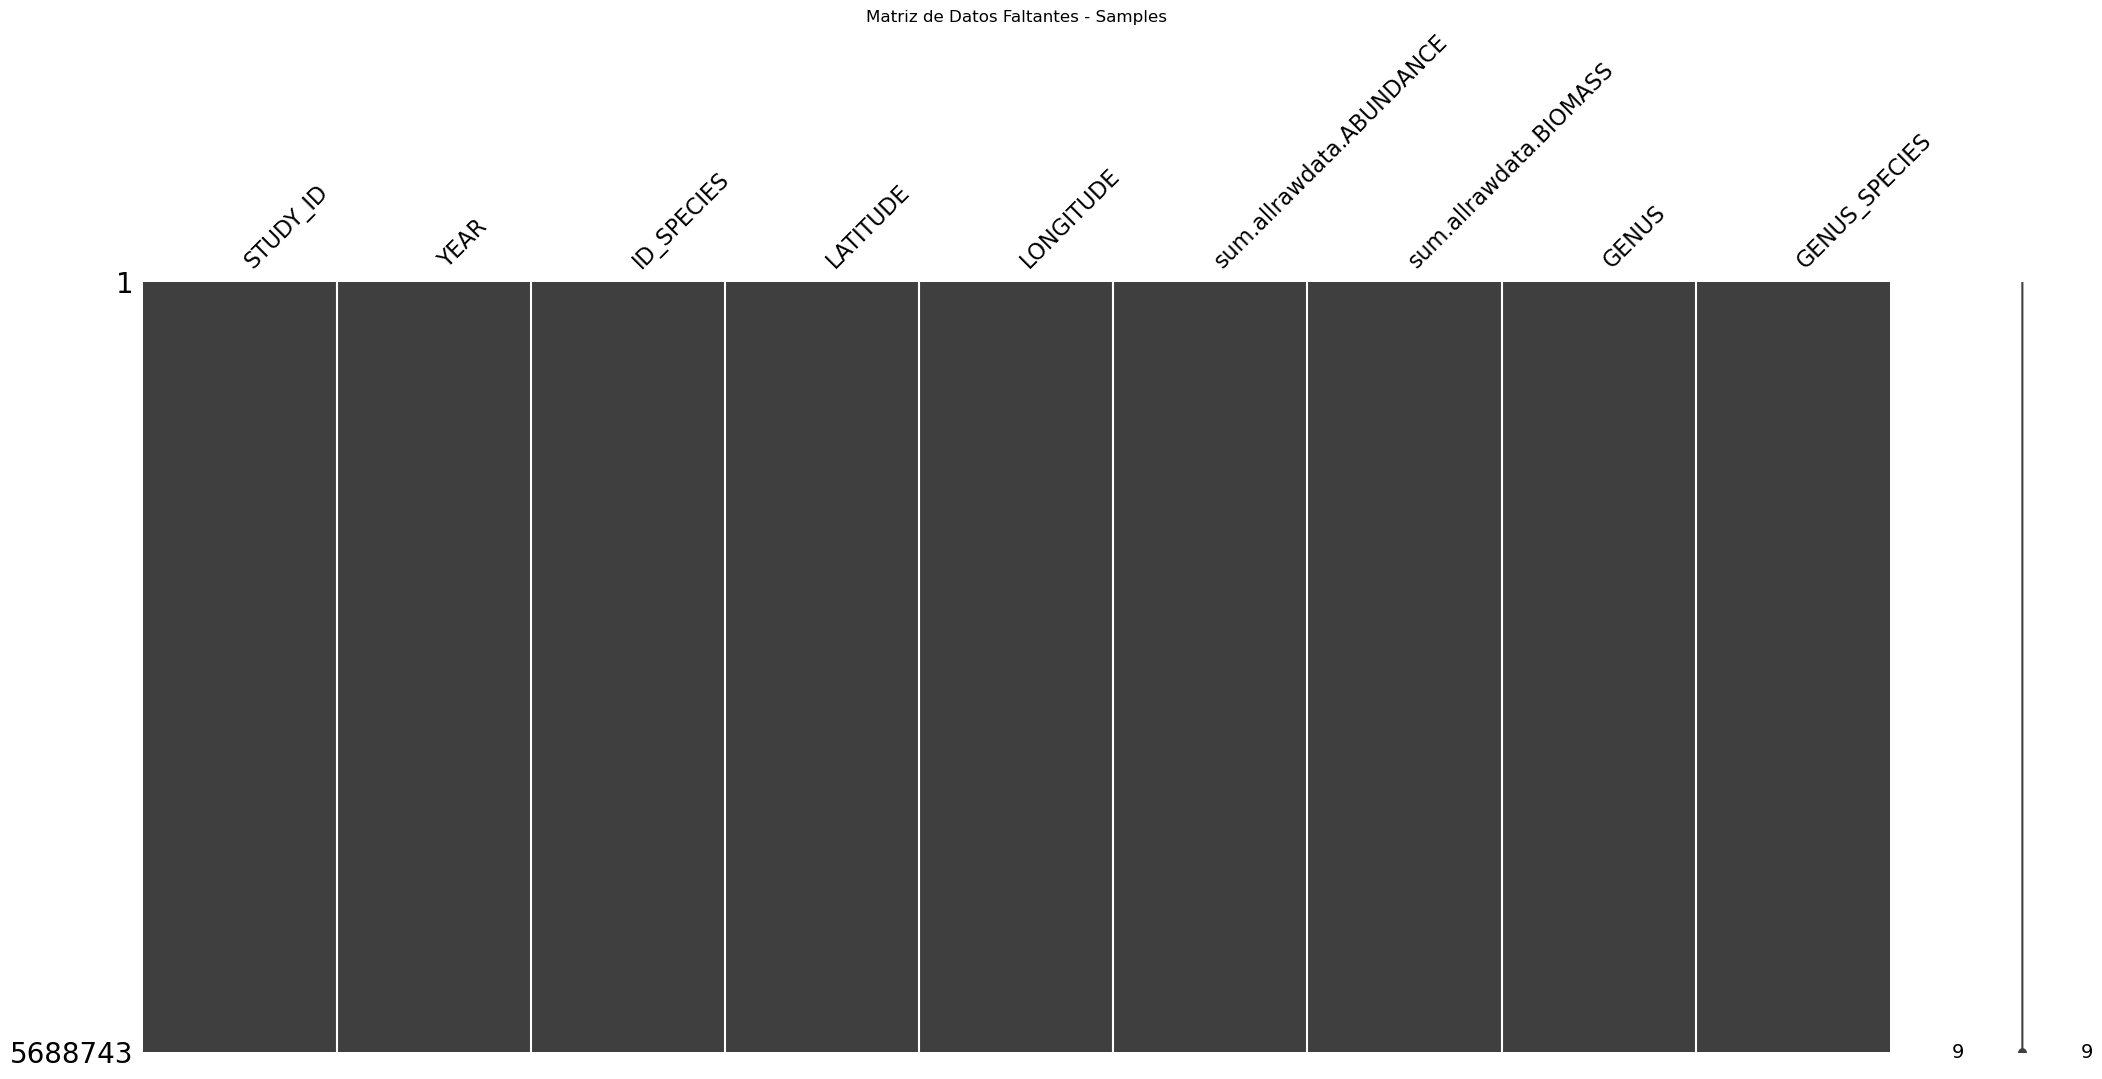

In [101]:
msno.matrix(samples_cleaned)
plt.title("Matriz de Datos Faltantes - Samples")
plt.show()  

Histogramas para variables numéricas

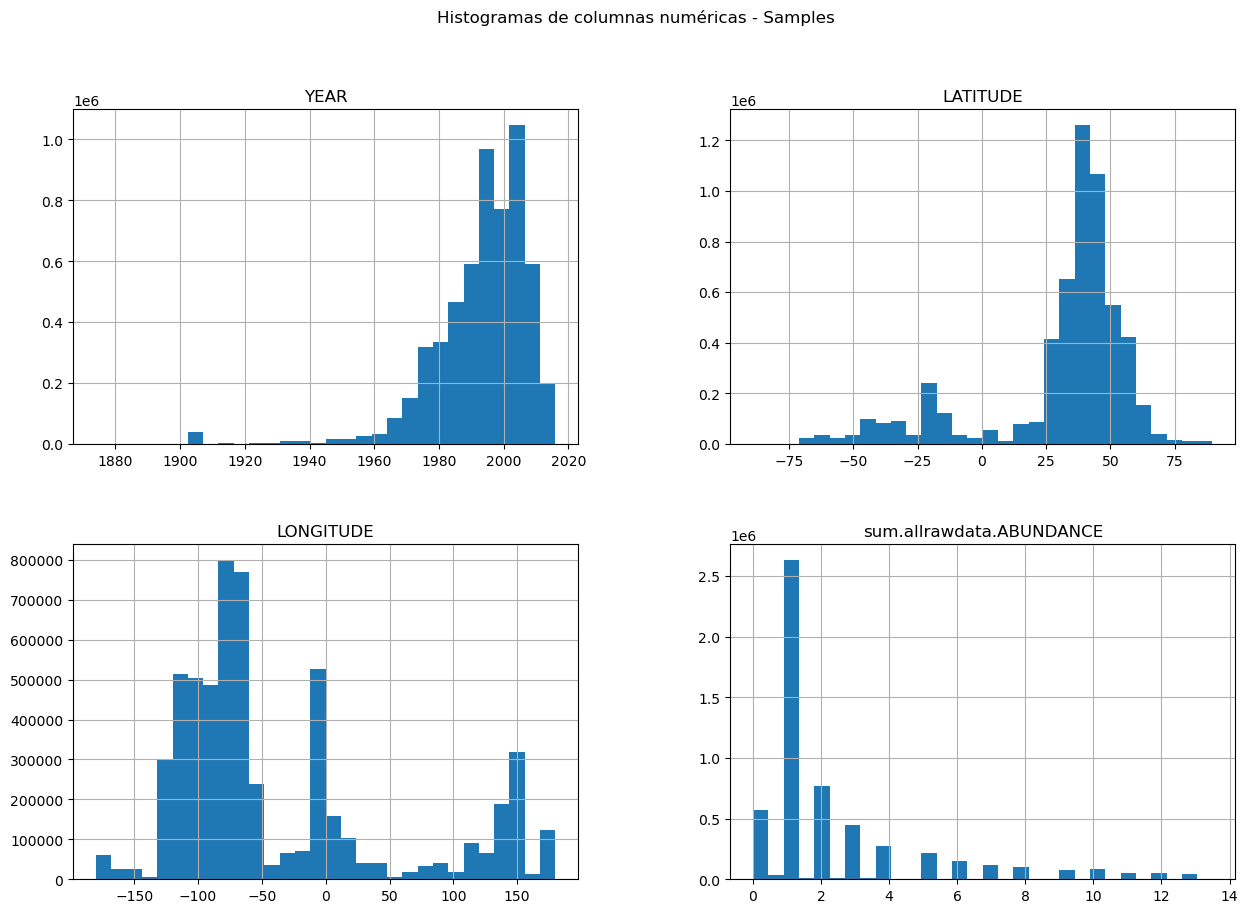

In [102]:
numeric_cols = ['YEAR', 'LATITUDE', 'LONGITUDE', 
                'sum.allrawdata.ABUNDANCE'] # 'sum.allrawdata.BIOMASS'
samples_cleaned[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histogramas de columnas numéricas - Samples")
plt.show()

Matriz de correlaciones:

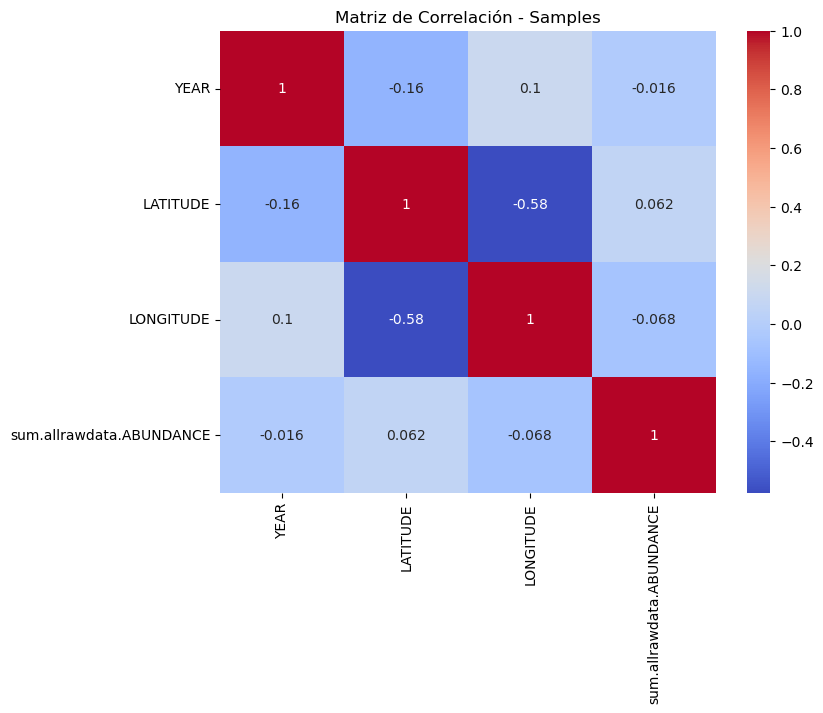

In [103]:
# Matriz de correlación para variables numéricas
corr = samples_cleaned[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación - Samples")
plt.show()

La matriz de correlación de Pearson nos indica que no hay ningun par de variables fuertemente relacionadas. Luego la abundancia media no depende ni de la zona geográfica ni del año en que el estudio fue realizado. Así pues, más adelante se investigará si la abundancia está más relacionada con el tipo de bioma o clima en donde se hizo el estudio.

Análisis espacial: Distribución geográfica según Abundancia

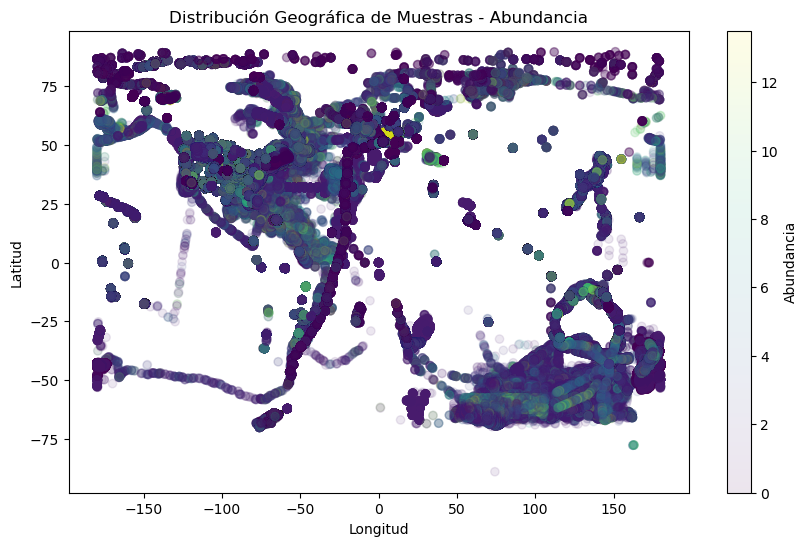

In [9]:
# Análisis espacial: Distribución geográfica según Abundancia
plt.figure(figsize=(10, 6))
scatter = plt.scatter(samples_cleaned['LONGITUDE'], samples_cleaned['LATITUDE'], 
                      c=samples_cleaned['sum.allrawdata.ABUNDANCE'], cmap='viridis', alpha=0.1)
plt.colorbar(scatter, label='Abundancia')
plt.title("Distribución Geográfica de Muestras - Abundancia")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

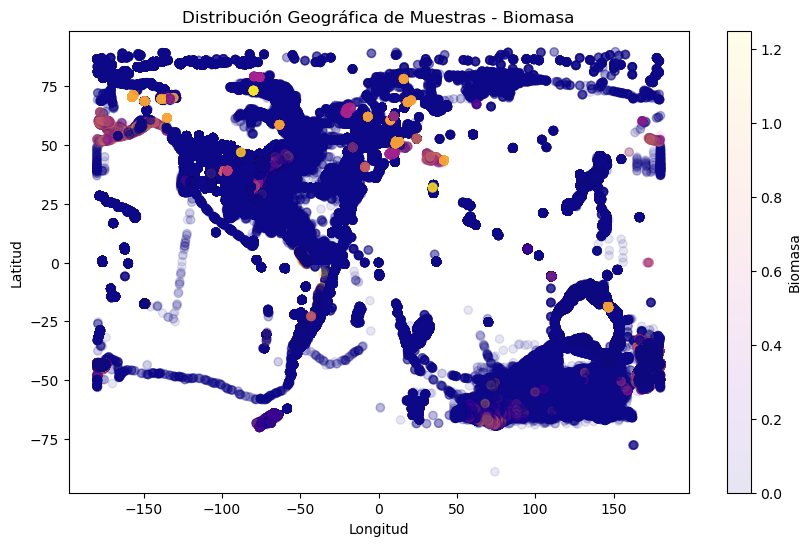

In [8]:
# Análisis espacial: Distribución geográfica según Biomasa
plt.figure(figsize=(10, 6))
scatter = plt.scatter(samples_cleaned['LONGITUDE'], samples_cleaned['LATITUDE'], 
                    c=samples_cleaned['sum.allrawdata.BIOMASS'], cmap='plasma', alpha=0.1)
plt.colorbar(scatter, label='Biomasa')
plt.title("Distribución Geográfica de Muestras - Biomasa")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

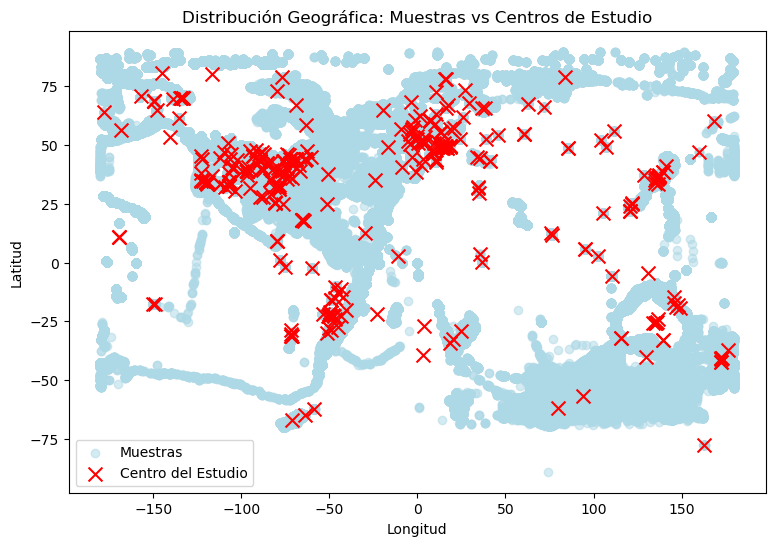

In [10]:
# Comparación espacial: Muestras vs Centros de Estudio
plt.figure(figsize=(9, 6))
plt.scatter(
  samples_cleaned['LONGITUDE'], samples_cleaned['LATITUDE'],
  c='lightblue', alpha=0.5, label='Muestras'
)
plt.scatter(
  studies_cleaned['CENT_LONG'], studies_cleaned['CENT_LAT'],
  c='red', marker='x', s=100, label='Centro del Estudio'
)
plt.title('Distribución Geográfica: Muestras vs Centros de Estudio')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(loc='lower left')
plt.show()

A continuación asociamos cada par de coordenadas (latitud y longitud) a un país realizando un cruce espacial con un shapefile (o dataset geográfico), para esto, utilizamos el dataset límites del mundo que provee GeoPandas

In [36]:
shapefile_path = "./world/ne_10m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)

Ahora, para asociar las muestras a los países, creamos una columna `geometry` a partir de LONGITUDE y LATITUDE para las muestras

In [37]:
geometry_samples = [Point(xy) for xy in zip(samples_cleaned['LONGITUDE'], samples_cleaned['LATITUDE'])]
gdf_samples = gpd.GeoDataFrame(samples_cleaned, geometry=geometry_samples)
gdf_samples.crs = "EPSG:4326"  # Sistema de coordenadas geográficas

Realizamos un spatial join para asignar el país a cada muestra:

In [38]:
samples_with_country = gpd.sjoin(gdf_samples, world, how="left", predicate="within")

Mostramos algunas filas para comprobar la asignación del país (la columna 'NAME' o similar dependerá del shapefile)

In [39]:
samples_with_country[['LONGITUDE', 'LATITUDE', 'sum.allrawdata.ABUNDANCE', 'NAME']].head()

,LONGITUDE,LATITUDE,sum.allrawdata.ABUNDANCE,NAME
0,-95.12,47.4,1.0,United States of America
1,-95.12,47.4,3.0,United States of America
2,-95.12,47.4,1.0,United States of America
3,-95.12,47.4,12.0,United States of America
4,-95.12,47.4,1.0,United States of America


Calculamos el número de muestras por país y graficamos:

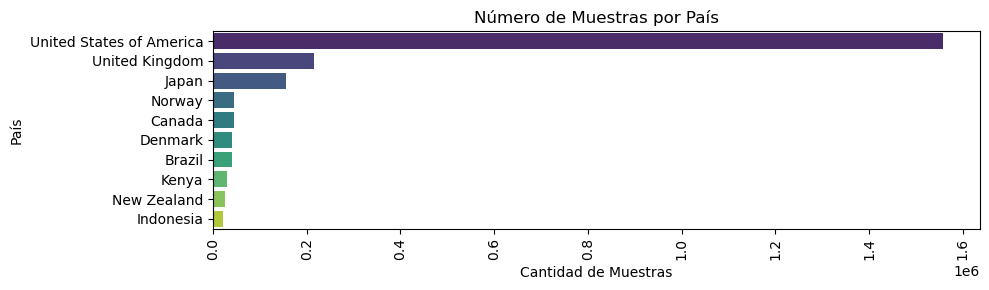

In [46]:
samples_by_country = samples_with_country.groupby('NAME').size().reset_index(name='counts')
samples_by_country.sort_values('counts', ascending=False, inplace=True)
# Gráfica: Número de muestras por país
plt.figure(figsize=(10, 3))
sns.barplot(data=samples_by_country[:10], x='counts', y='NAME', palette="viridis", hue='NAME')
plt.xticks(rotation=90)
plt.title("Número de Muestras por País")
plt.xlabel("Cantidad de Muestras")
plt.ylabel("País")
plt.tight_layout()
plt.show()

Para facilitar la visualización, graficamos en escala logarítmica:

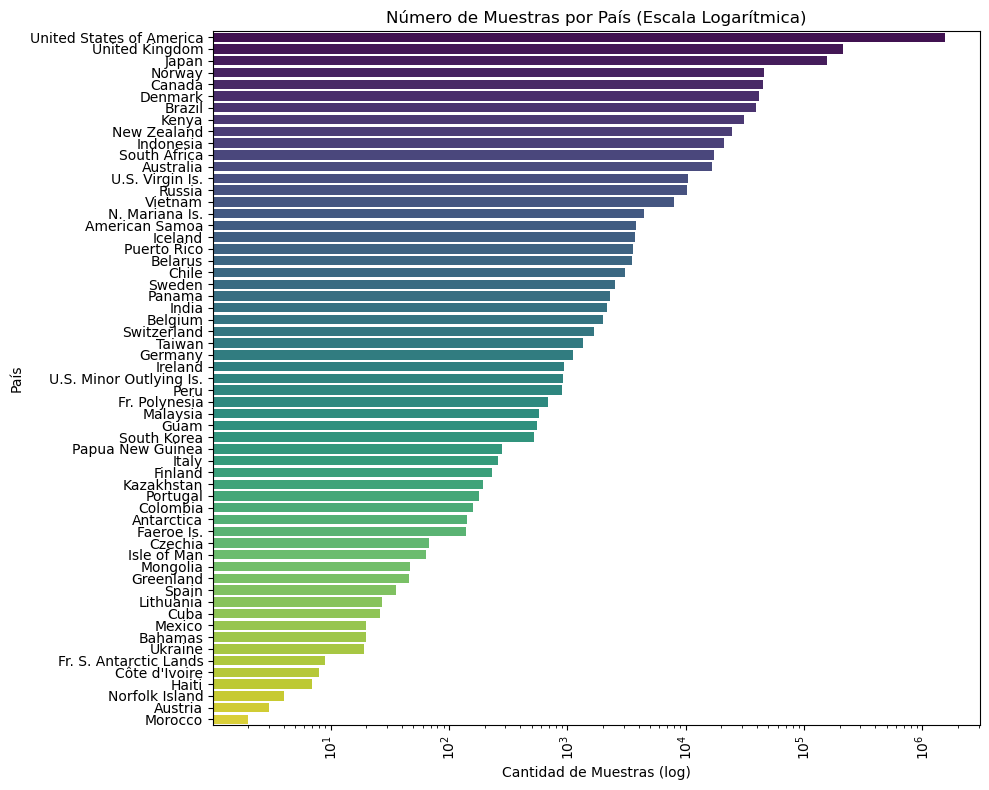

In [47]:
# Gráfica: Número de muestras por país (log)
plt.figure(figsize=(10, 8))
sns.barplot(data=samples_by_country, x='counts', y='NAME', palette="viridis", hue='NAME')
plt.xscale("log")  # Aplicar escala logarítmica
plt.xticks(rotation=90)
plt.title("Número de Muestras por País (Escala Logarítmica)")
plt.xlabel("Cantidad de Muestras (log)")
plt.ylabel("País")
plt.tight_layout()
plt.show()

### Dataframe Studies

In [59]:
print("Dimensiones de studies:", studies_cleaned.shape)

Dimensiones de studies: (122, 20)


In [60]:
studies_cleaned.head(5)

,STUDY_ID,REALM,CLIMATE,HABITAT,PROTECTED_AREA,BIOME_MAP,TAXA,ORGANISMS,HAS_PLOT,DATA_POINTS,START_YEAR,END_YEAR,CENT_LAT,CENT_LONG,NUMBER_OF_SPECIES,NUMBER_OF_SAMPLES,TOTAL,GRAIN_SQ_KM,AREA_SQ_KM,DATE_STUDY_ADDED
0,10,Terrestrial,Temperate,Woodland,False,Temperate broadleaf and mixed forests,Terrestrial plants,woody plants,Y,3,1984,1996,47.40000,-95.120000,25,191,1406,0.000004,0.000006,Oct-12
14,58,Terrestrial,Tropical,Long term monitoring site,False,Tropical and subtropical dry broadleaf forests,Birds,birds,Y,18,1991,2008,18.19000,-65.430000,31,6,1171,0.001962,0.160000,Oct-12
15,59,Terrestrial,Temperate,Urban / Desert,False,Deserts and xeric shrublands,Mammals,rodents,Y,26,1977,2002,30.32260,-103.501000,29,2,427,0.002500,0.002500,Oct-12
17,63,Terrestrial,Temperate,Ponds,False,Small lake ecosystems,Terrestrial invertebrates,dragonflies,S,29,1959,1988,52.42210,-0.180928,5,1,132,0.000000,2.080000,Oct-12
33,87,Marine,Temperate,Seaweed beds,False,Temperate shelf and seas ecoregions,Marine plants,Phytoplankton,S,9,1982,1990,51.54925,3.912051,109,2,6155,0.000000,0.159520,Oct-12


Información general

In [61]:
print(studies_cleaned.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, 0 to 365
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   STUDY_ID           122 non-null    int64  
 1   REALM              122 non-null    object 
 2   CLIMATE            122 non-null    object 
 3   HABITAT            122 non-null    object 
 4   PROTECTED_AREA     122 non-null    bool   
 5   BIOME_MAP          122 non-null    object 
 6   TAXA               122 non-null    object 
 7   ORGANISMS          122 non-null    object 
 8   HAS_PLOT           122 non-null    object 
 9   DATA_POINTS        122 non-null    int64  
 10  START_YEAR         122 non-null    int64  
 11  END_YEAR           122 non-null    int64  
 12  CENT_LAT           122 non-null    float64
 13  CENT_LONG          122 non-null    float64
 14  NUMBER_OF_SPECIES  122 non-null    int64  
 15  NUMBER_OF_SAMPLES  122 non-null    int64  
 16  TOTAL              122 non-null

Estadísticos descriptivos:

In [63]:
print(studies_cleaned.describe(), "\n")

         STUDY_ID  DATA_POINTS   START_YEAR     END_YEAR    CENT_LAT  \
count  122.000000   122.000000   122.000000   122.000000  122.000000   
mean   378.426230     9.172131  1990.516393  2004.819672   37.157286   
std    105.548698     9.124205    12.863064     8.378462   25.287357   
min     10.000000     2.000000  1957.000000  1982.000000  -22.608900   
25%    325.250000     3.000000  1982.000000  2000.250000   31.752498   
50%    392.500000     4.500000  1992.000000  2007.000000   43.469365   
75%    454.500000    13.000000  2000.000000  2010.750000   50.561438   
max    533.000000    38.000000  2015.000000  2018.000000   78.953570   

        CENT_LONG  NUMBER_OF_SPECIES  NUMBER_OF_SAMPLES        TOTAL  \
count  122.000000         122.000000         122.000000   122.000000   
mean   -20.724733          54.278689         177.163934  1250.745902   
std     79.289657          60.602793         328.089142  1604.710692   
min   -178.000000           3.000000           1.000000    12.0

Conteo de datos 

In [64]:
# Conteo de valores faltantes por columna
print("Valores faltantes en studies:")
print(studies_cleaned.isnull().sum(), "\n")

Valores faltantes en studies:
STUDY_ID             0
REALM                0
CLIMATE              0
HABITAT              0
PROTECTED_AREA       0
BIOME_MAP            0
TAXA                 0
ORGANISMS            0
HAS_PLOT             0
DATA_POINTS          0
START_YEAR           0
END_YEAR             0
CENT_LAT             0
CENT_LONG            0
NUMBER_OF_SPECIES    0
NUMBER_OF_SAMPLES    0
TOTAL                0
GRAIN_SQ_KM          0
AREA_SQ_KM           0
DATE_STUDY_ADDED     0
dtype: int64 



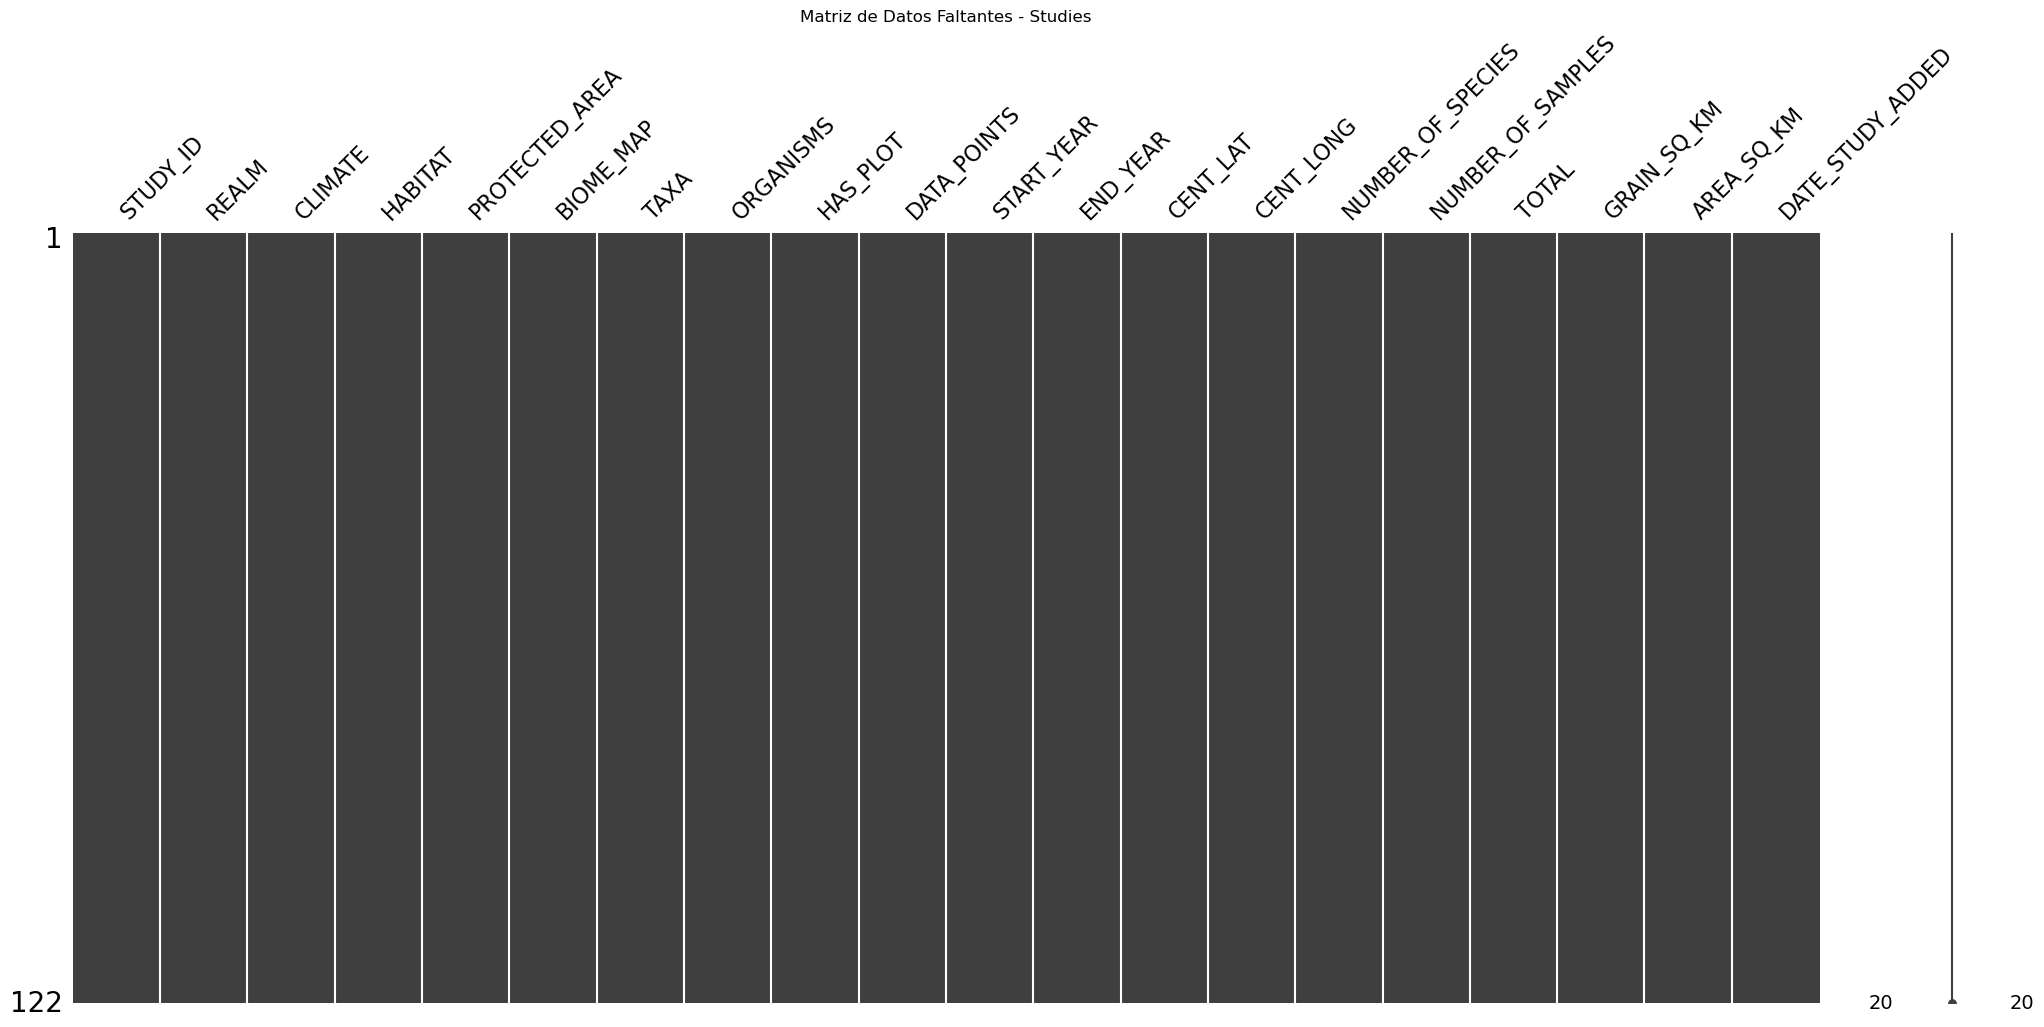

In [65]:
msno.matrix(studies_cleaned)
plt.title("Matriz de Datos Faltantes - Studies")
plt.show()

Histogramas para variables numéricas

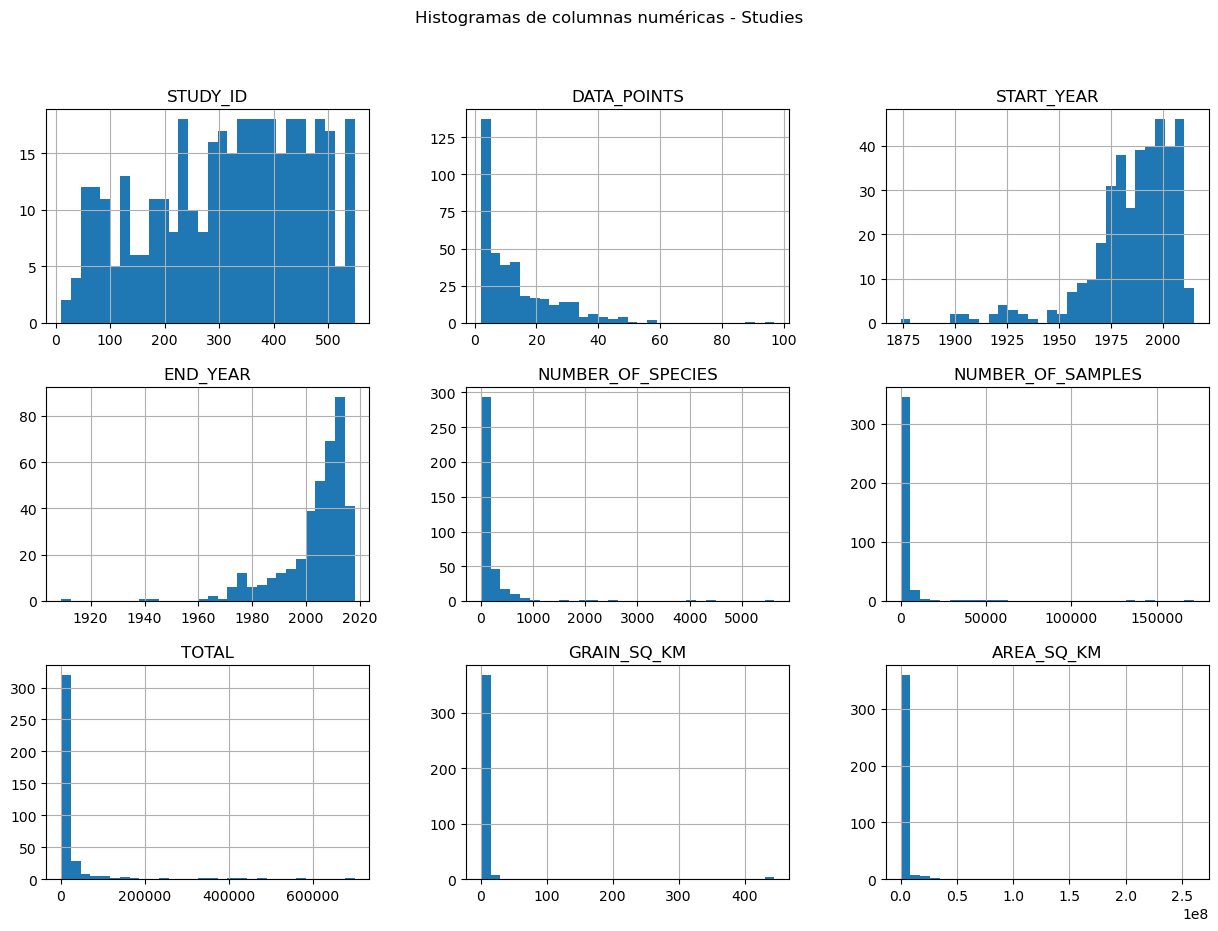

In [52]:
# Histogramas para algunas columnas numéricas relevantes
numeric_cols = ['STUDY_ID', 'DATA_POINTS', 'START_YEAR', 'END_YEAR', 
                'NUMBER_OF_SPECIES', 'NUMBER_OF_SAMPLES', 'TOTAL', 
                'GRAIN_SQ_KM', 'AREA_SQ_KM']
studies_cleaned[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle("Histogramas de columnas numéricas - Studies")
plt.show()

Conteo para algunas variables categóricas

In [59]:
def plot_count(feature, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))

    # Configuración de countplot (ahora con `y` y `hue` correctamente definidos)
    g = sns.countplot(y=df[feature], order=df[feature].value_counts().index[:20], 
                      palette='Oranges', hue=df[feature], legend=False)

    g.set_title(f"Number and percentage of {title}")

    # Ajuste de etiquetas de porcentaje dentro de las barras
    for p in ax.patches:
        width = p.get_width()  # Ahora tomamos el ancho de la barra (valor de conteo)
        ax.text(width + 3,  # Coloca la etiqueta a la derecha de la barra
                p.get_y() + p.get_height()/2,  # Centra en la barra
                '{:1.2f}%'.format(100 * width / total), 
                ha="center", va="center") 

    plt.show()

Veamos el número y porcentaje de las especies por cada uno de los reinos globales

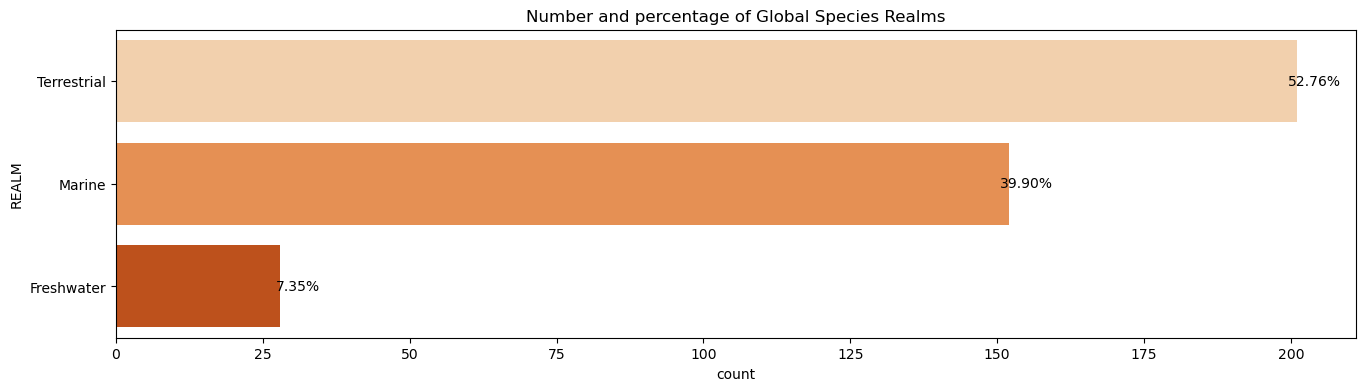

In [61]:
# Llamar la función
plot_count("REALM", "Global Species Realms", studies, 4)

Podemos hacer lo mismo del gráfico anterior, pero esta vez para climas en lugar de ecosistemas:

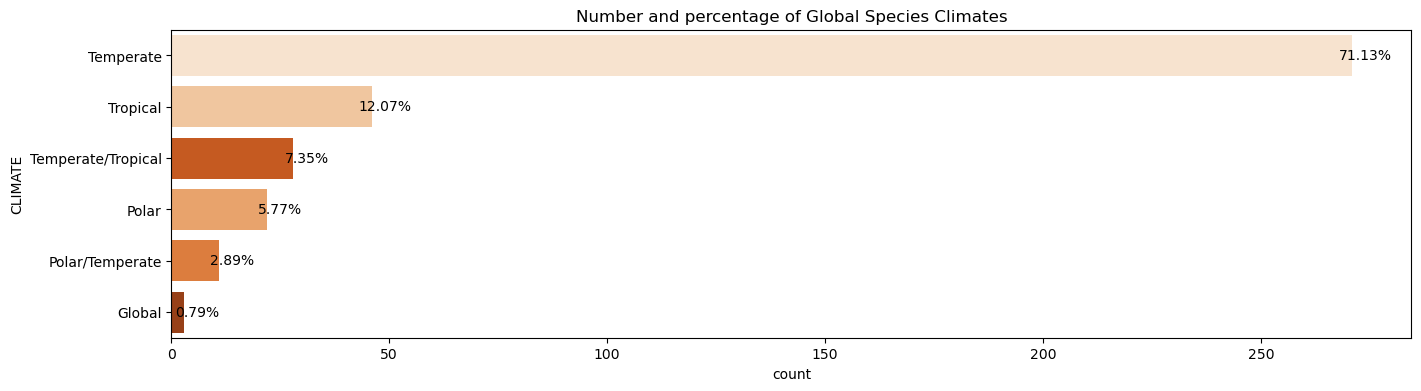

In [63]:
plot_count("CLIMATE", "Global Species Climates", studies,4)

Podemos ver ahora el grafico de barras que cuenta la biomasa o abundancia dependiendo del clima de la zona del estudio

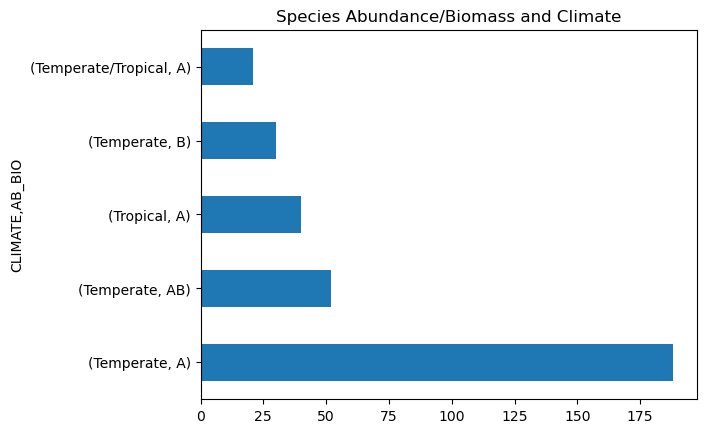

In [77]:
studies[['CLIMATE', 'AB_BIO']].value_counts().head().plot(kind='barh')

plt.title('Species Abundance/Biomass and Climate');

También podemos observar el numero y porcentaje de especies respecto a si el territorio es protegido o no. De aquí vemos que la mayoría de los estudios fueron llevados a cabo en zonas no protegidas.

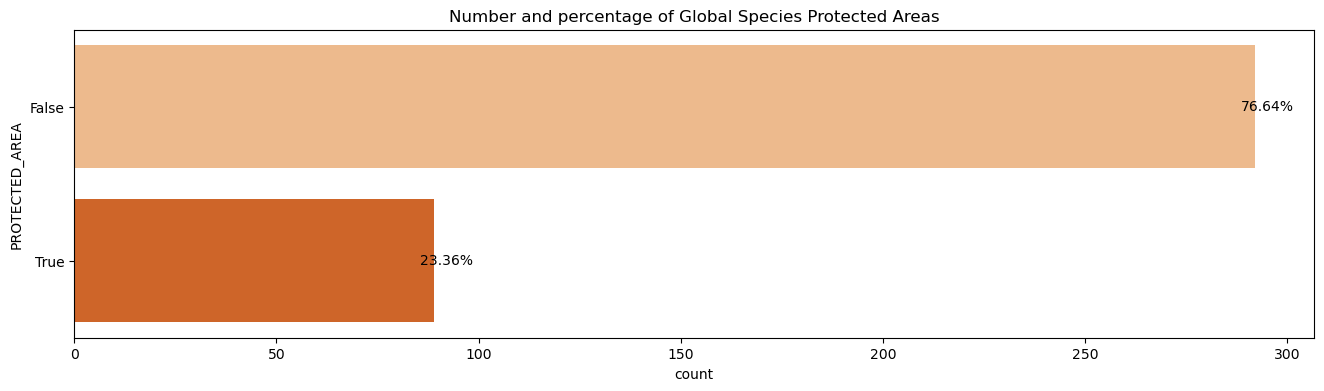

In [79]:
plot_count("PROTECTED_AREA", "Global Species Protected Areas", studies,4)

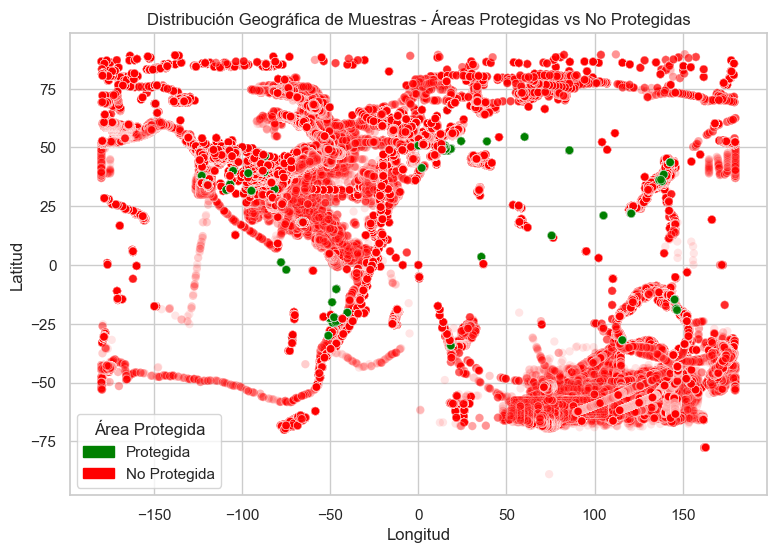

In [90]:
import matplotlib.patches as mpatches

merged_data = samples.merge(studies[['STUDY_ID', 'PROTECTED_AREA']], on='STUDY_ID', how='left')
merged_data['PROTECTED_AREA'] = merged_data['PROTECTED_AREA'].astype(str)
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=merged_data, 
    x="LONGITUDE", 
    y="LATITUDE", 
    hue="PROTECTED_AREA", 
    palette={"True": "green", "False": "red"}, 
    alpha=0.1,
    legend=False
)

legend_labels = [
    mpatches.Patch(color="green", label="Protegida"),
    mpatches.Patch(color="red", label="No Protegida")
]
plt.legend(handles=legend_labels, title="Área Protegida", loc="lower left")

plt.title("Distribución Geográfica de Muestras - Áreas Protegidas vs No Protegidas")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.show()

También podemos ver el numero y porcentaje del tipo de especies en los estudios

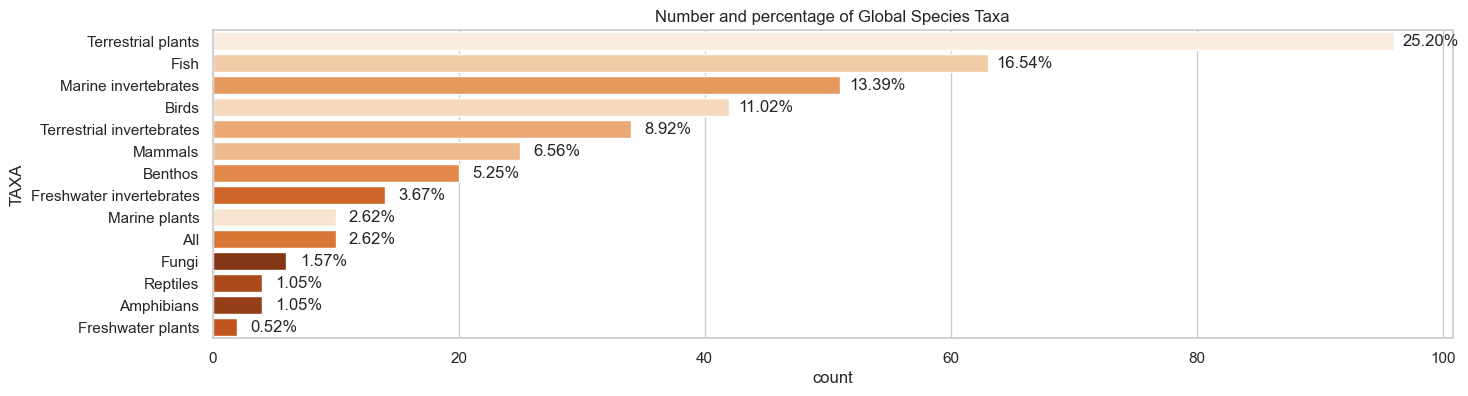

In [91]:
plot_count("TAXA", "Global Species Taxa", studies,4)

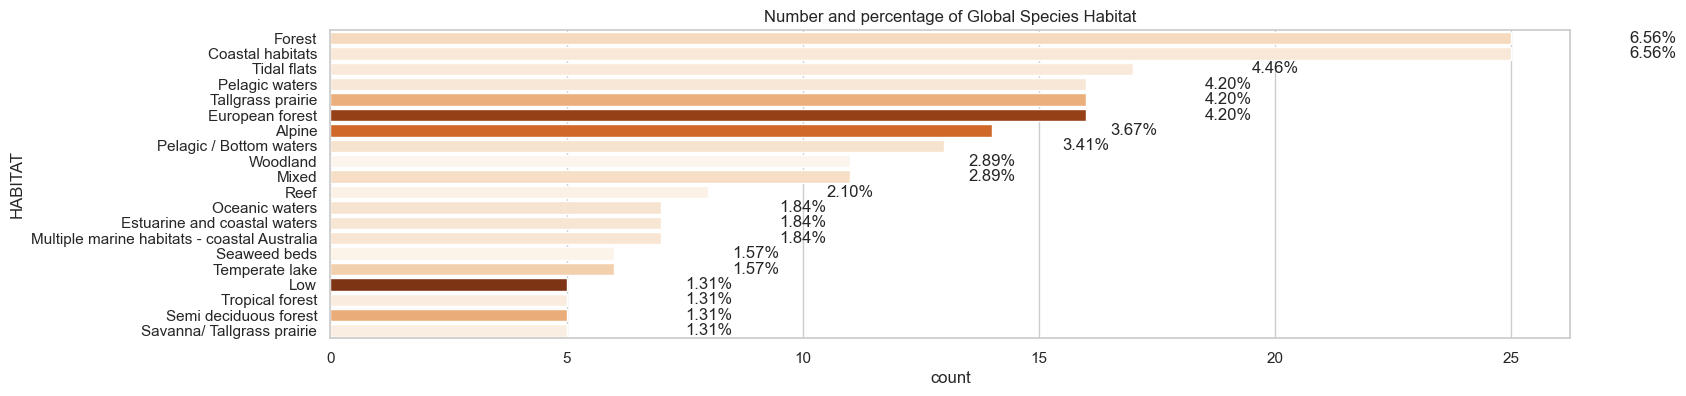

In [93]:
plot_count("HABITAT", "Global Species Habitat", studies,4)

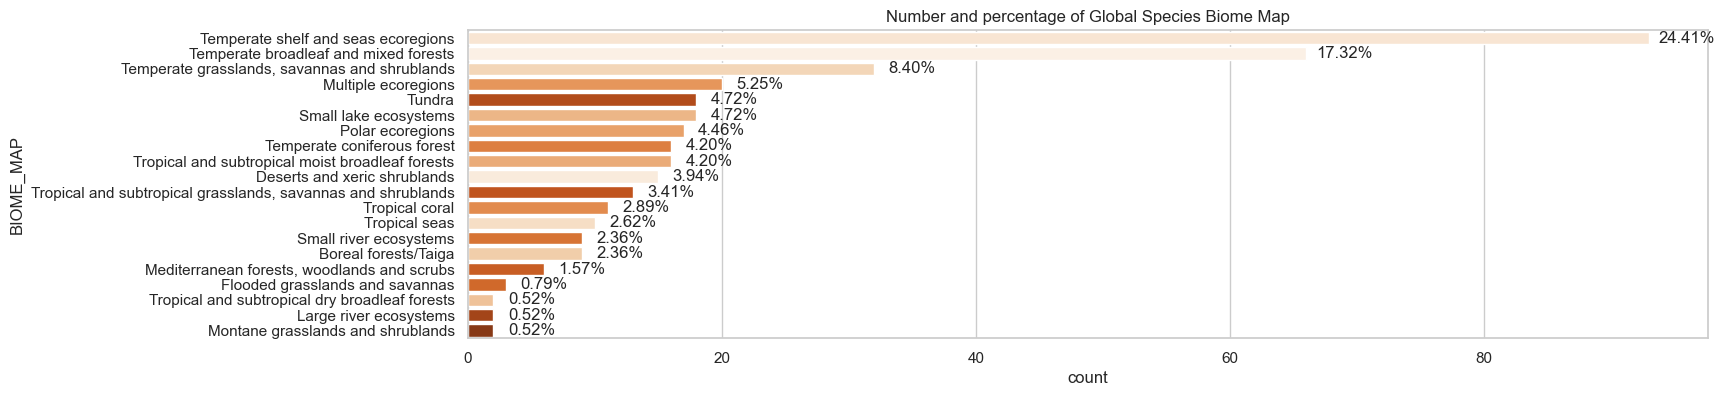

In [99]:
plot_count("BIOME_MAP", "Global Species Biome Map", studies,4)

Análisis temporal: Tendencias anuales 

In [100]:
# Agrupar por año para obtener la abundancia y biomasa promedio
yearly_data = samples.groupby('YEAR').agg({
  'sum.allrawdata.ABUNDANCE': 'mean',
  'sum.allrawdata.BIOMASS': 'mean'
}).reset_index()

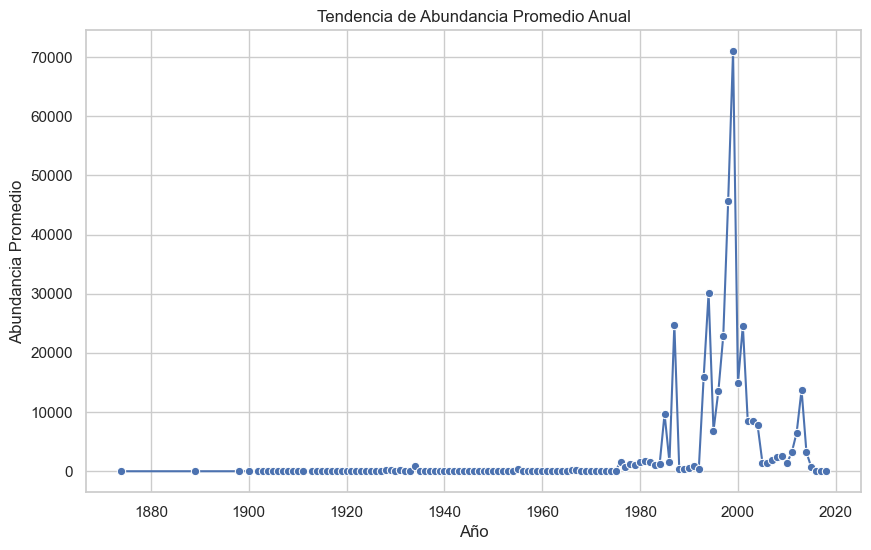

In [101]:
# Gráfica: Abundancia promedio anual
plt.figure()
sns.lineplot(data=yearly_data, x='YEAR', y='sum.allrawdata.ABUNDANCE', marker='o')
plt.title('Tendencia de Abundancia Promedio Anual')
plt.xlabel('Año')
plt.ylabel('Abundancia Promedio')
plt.grid(True)
plt.show()

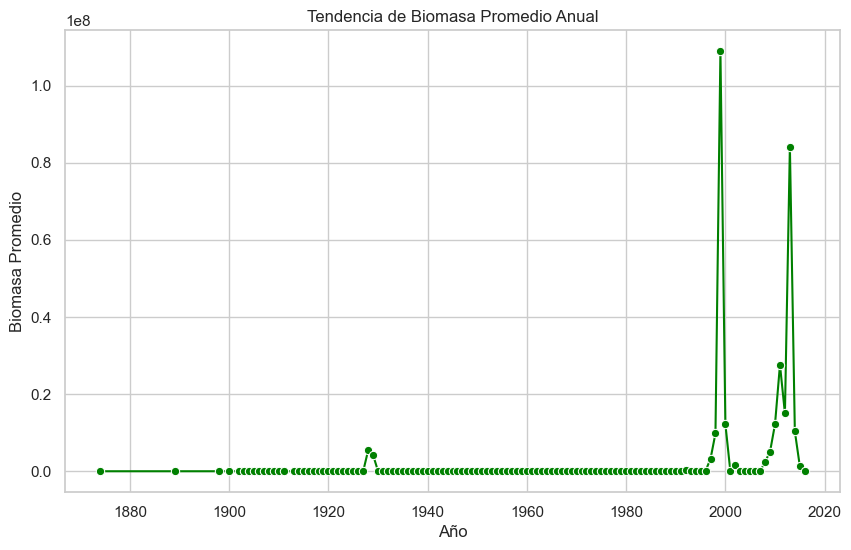

In [102]:
# Gráfica: Biomasa promedio anual
plt.figure()
sns.lineplot(data=yearly_data, x='YEAR', y='sum.allrawdata.BIOMASS', marker='o', color='green')
plt.title('Tendencia de Biomasa Promedio Anual')
plt.xlabel('Año')
plt.ylabel('Biomasa Promedio')
plt.grid(True)
plt.show()